이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_sample_image
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

# 최신 버전 다운로드
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

# 디렉토리 내의 파일 목록 확인
files_in_directory = os.listdir(path)
print("Files in directory:", files_in_directory)

# 데이터 경로 설정
train_data_path = os.path.join(path, 'fashion-mnist_train.csv')
test_data_path = os.path.join(path, 'fashion-mnist_test.csv')

Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4
Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


NameError: name 'os' is not defined

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [ ]:
# 데이터 로드
try:
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)

    # 데이터 크기 출력
    print("Train Data Shape:", train_data.shape)  # Train 데이터의 크기
    print("Test Data Shape:", test_data.shape)    # Test 데이터의 크기
    print('-'*50)
    # 데이터 요약 정보 출력
    print("\nTrain Data Summary:")
    print(train_data.describe())
    print('-'*50)
    print("\nTest Data Summary:")
    print(test_data.describe())
    print('-'*50)
    # 결측치 여부 확인
    print("\nMissing values in Train Data:")
    print(train_data.isnull().sum().sum())  # Train 데이터의 결측치 수
    print('-'*50)
    print("\nMissing values in Test Data:")
    print(test_data.isnull().sum().sum())    # Test 데이터의 결측치 수
    print('-'*50)
    # 데이터의 첫 몇 행 출력
    print("\nFirst 5 rows of Train Data:")
    print(train_data.head())
    print('-'*50)
    print("\nFirst 5 rows of Test Data:")
    print(test_data.head())
    print('-'*50)

except FileNotFoundError as e:
    print(f"File not found: {e}")

Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)
--------------------------------------------------

Train Data Summary:
              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000 

### Data중 첫 번째 이미지를 보여주세요.

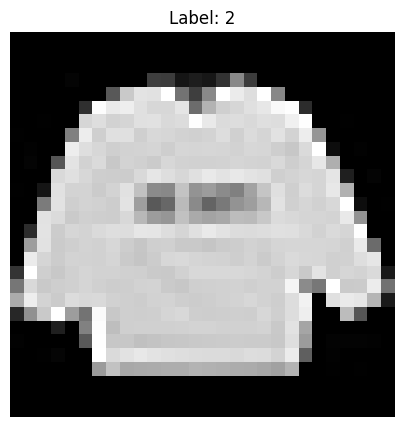

In [ ]:
# 첫 번째 이미지와 레이블 가져오기
first_image = train_data.iloc[0, 1:].values.reshape(28, 28)  # 첫 번째 이미지 데이터 (28x28)
first_label = train_data.iloc[0, 0]  # 첫 번째 이미지의 레이블

# 이미지 시각화
plt.figure(figsize=(5, 5))
plt.imshow(first_image, cmap='gray')
plt.title(f'Label: {first_label}')
plt.axis('off')  # 축 숨기기
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [ ]:
# 사용자 정의 데이터셋 클래스
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 이미지 데이터 가져오기 및 정규화
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.float32)  # 이미지 데이터
        image /= 255.0  # 0-255 범위를 0-1로 정규화
        label = self.data.iloc[idx, 0]  # 레이블

        if self.transform:
            image = self.transform(image)

        return image, label


### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

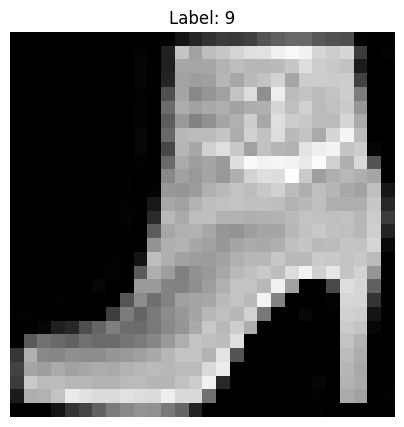

In [ ]:
!pip install torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 추가적인 이미지 전처리 (예: 데이터 증강)
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    # transforms.Normalize((0.5,), (0.5,)),  # 정규화 (여기서는 생략)
])

# 데이터셋 및 데이터로더 생성
train_dataset = FashionMNISTDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 첫 번째 배치에서 이미지 및 레이블 시각화
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 첫 번째 이미지 시각화
plt.figure(figsize=(5, 5))
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')  # 축 숨기기
plt.show()

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

(더블클릭하여 이곳에 작성)

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [ ]:
# 데이터 준비
X_train = train_data.iloc[:, 1:].values  # 이미지 데이터 (픽셀 값)
y_train = train_data.iloc[:, 0].values    # 레이블

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 적용
pca_50 = PCA(n_components=50)  # 50개의 주성분으로 변환
X_train_pca_50 = pca_50.fit_transform(X_train_scaled)

# 변환된 데이터의 shape 출력
print("Original shape:", X_train.shape)
print("Transformed shape:", X_train_pca_50.shape)


NameError: name 'train_data' is not defined

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [ ]:
# 각 주성분의 설명된 분산 비율 출력
explained_variance_50 = pca_50.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
print(explained_variance_50)

# 설명된 분산 비율의 합계 출력
print("\nTotal explained variance ratio (first 50 components):", explained_variance_50.sum())

Explained variance ratio for each principal component:
[0.22057176 0.14395563 0.05458802 0.05116399 0.04069273 0.03012154
 0.02750481 0.02325871 0.01694438 0.01309833 0.01161488 0.00963108
 0.00890642 0.00856623 0.00743049 0.00730157 0.00657498 0.00632692
 0.00623657 0.0058046  0.00515707 0.00511548 0.00472764 0.00453557
 0.00438423 0.00416784 0.00395056 0.00393244 0.00378355 0.00374478
 0.00368528 0.00353646 0.00336422 0.00330015 0.00329434 0.00319736
 0.00305999 0.00293714 0.00289203 0.00280918 0.00271998 0.00265986
 0.00255732 0.00253773 0.00245191 0.00243254 0.0023872  0.00228126
 0.00223339 0.00215709]

Total explained variance ratio (first 50 components): 0.800287255442094


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [ ]:
# 총 설명된 분산 비율 출력
print("\nTotal explained variance ratio (first 50 components):", explained_variance_50.sum())

# 재구성 및 재구성 오차 계산 (50차원)
X_train_reconstructed_50 = pca_50.inverse_transform(X_train_pca_50)
X_train_reconstructed_50 = scaler.inverse_transform(X_train_reconstructed_50)
reconstruction_error_50 = mean_squared_error(X_train, X_train_reconstructed_50)

print("Reconstruction Error (MSE) for 50 components:", reconstruction_error_50)


Total explained variance ratio (first 50 components): 0.800287255442094
Reconstruction Error (MSE) for 50 components: 931.8652256154422


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [ ]:
# PCA 적용 (30차원으로 축소)
pca_30 = PCA(n_components=30)  # 30개의 주성분으로 변환
X_train_pca_30 = pca_30.fit_transform(X_train_scaled)

# 설명된 분산 비율 출력 (30차원)
explained_variance_30 = pca_30.explained_variance_ratio_
print("\nExplained variance ratio for each principal component (30 components):")
print(explained_variance_30)

# 총 설명된 분산 비율 출력
print("\nTotal explained variance ratio (first 30 components):", explained_variance_30.sum())

# 재구성 및 재구성 오차 계산 (30차원)
X_train_reconstructed_30 = pca_30.inverse_transform(X_train_pca_30)
X_train_reconstructed_30 = scaler.inverse_transform(X_train_reconstructed_30)
reconstruction_error_30 = mean_squared_error(X_train, X_train_reconstructed_30)

print("Reconstruction Error (MSE) for 30 components:", reconstruction_error_30)


Explained variance ratio for each principal component (30 components):
[0.22057176 0.14395563 0.05458802 0.05116399 0.04069273 0.03012154
 0.02750481 0.02325871 0.01694438 0.01309833 0.01161488 0.00963108
 0.00890642 0.00856623 0.00743049 0.00730157 0.00657498 0.00632692
 0.00623657 0.0058046  0.00515707 0.00511548 0.00472764 0.00453557
 0.00438423 0.00416784 0.00395056 0.00393244 0.00378355 0.00374478]

Total explained variance ratio (first 30 components): 0.7437928238919893
Reconstruction Error (MSE) for 30 components: 1163.67683306021


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

50차원일때 분산 비율은 80.03% 였는데 #30차원일때 분산 비율은 74.38%이다. 즉 차원 축소했을때 더 많은 정보 손실이 발생했다.

50차원일때 mse는 931.86
30차원일때 mse는 1163.67  마찬가지로 더 많은 정보 손실이 발생했다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [ ]:
# PCA 적용 (2차원으로 축소)
pca_2 = PCA(n_components=2)  # 2개의 주성분으로 변환
X_train_pca_2 = pca_2.fit_transform(X_train_scaled)

# 설명된 분산 비율 출력 (2차원)
explained_variance_2 = pca_2.explained_variance_ratio_
print("\nExplained variance ratio for each principal component (2 components):")
print(explained_variance_2)

# 총 설명된 분산 비율 출력
print("\nTotal explained variance ratio (first 2 components):", explained_variance_2.sum())

# 재구성 및 재구성 오차 계산 (2차원)
X_train_reconstructed_2 = pca_2.inverse_transform(X_train_pca_2)
X_train_reconstructed_2 = scaler.inverse_transform(X_train_reconstructed_2)
reconstruction_error_2 = mean_squared_error(X_train, X_train_reconstructed_2)

print("Reconstruction Error (MSE) for 2 components:", reconstruction_error_2)


Explained variance ratio for each principal component (2 components):
[0.22057176 0.14395563]

Total explained variance ratio (first 2 components): 0.3645273855029696
Reconstruction Error (MSE) for 2 components: 3034.398282657217


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

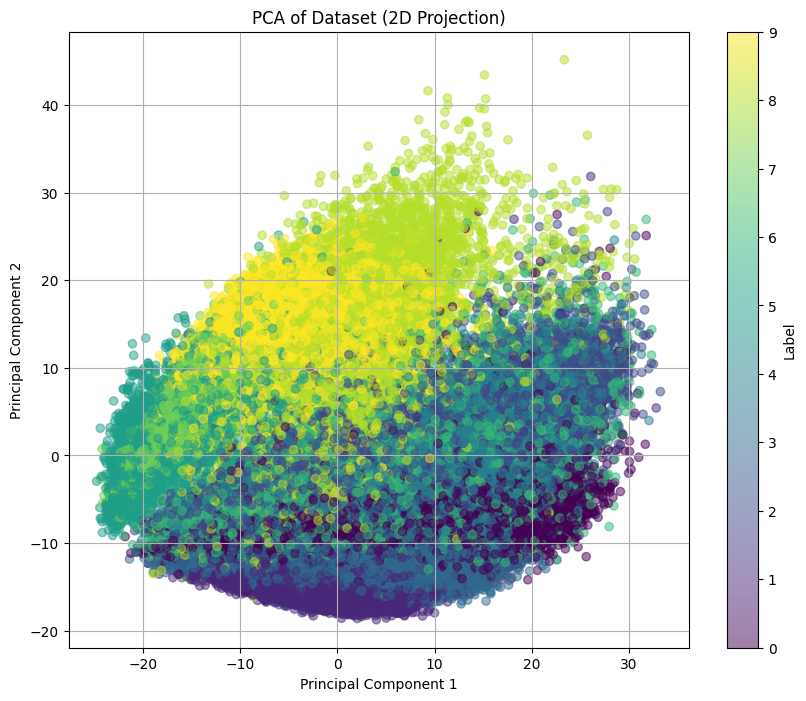

In [ ]:
# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('PCA of Dataset (2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Label')
plt.grid()
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

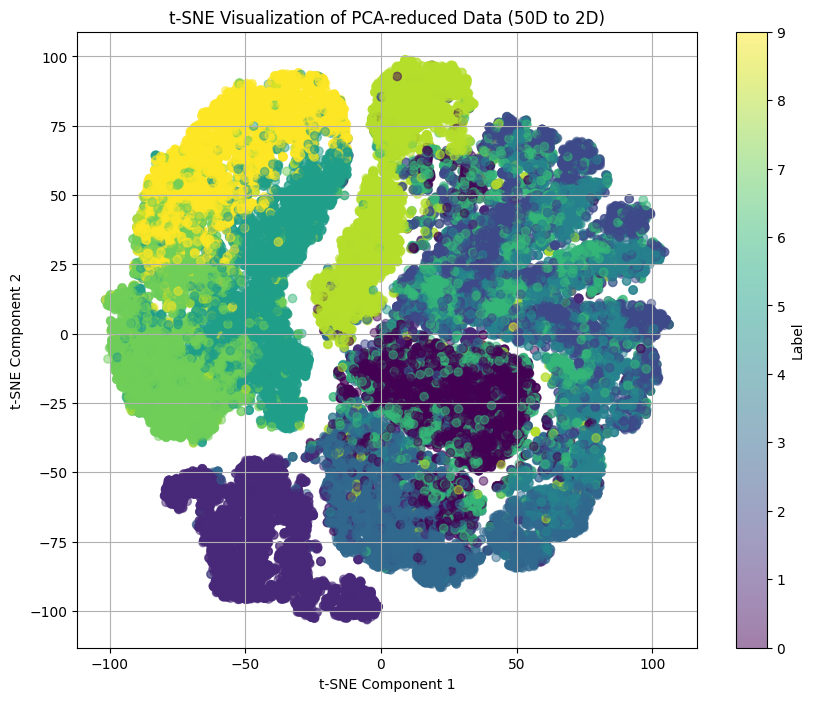

In [ ]:
# t-SNE 적용 (2차원으로 축소)
tsne_50 = TSNE(n_components=2, random_state=42)
X_train_tsne_50 = tsne_50.fit_transform(X_train_pca_50)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_tsne_50[:, 0], X_train_tsne_50[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of PCA-reduced Data (50D to 2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Label')
plt.grid()
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

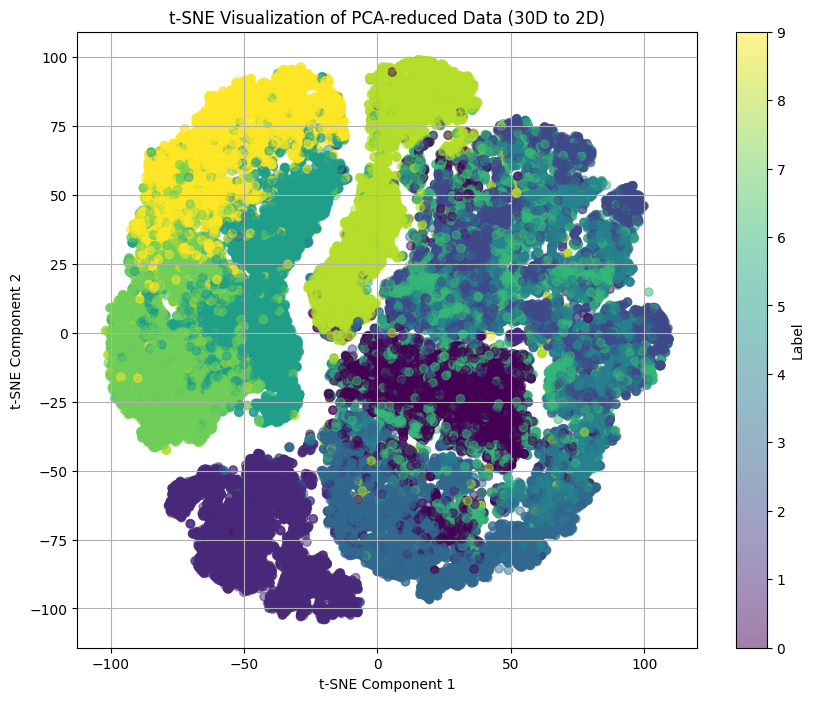

In [ ]:
# t-SNE 적용 (2차원으로 축소)
tsne_30 = TSNE(n_components=2, random_state=42)
X_train_tsne_30 = tsne_30.fit_transform(X_train_pca_30)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_tsne_30[:, 0], X_train_tsne_30[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of PCA-reduced Data (30D to 2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Label')
plt.grid()
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_train_pca_50)

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [ ]:
# K-means 적용 (군집 개수 10개로 설정)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_train_pca_50)

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

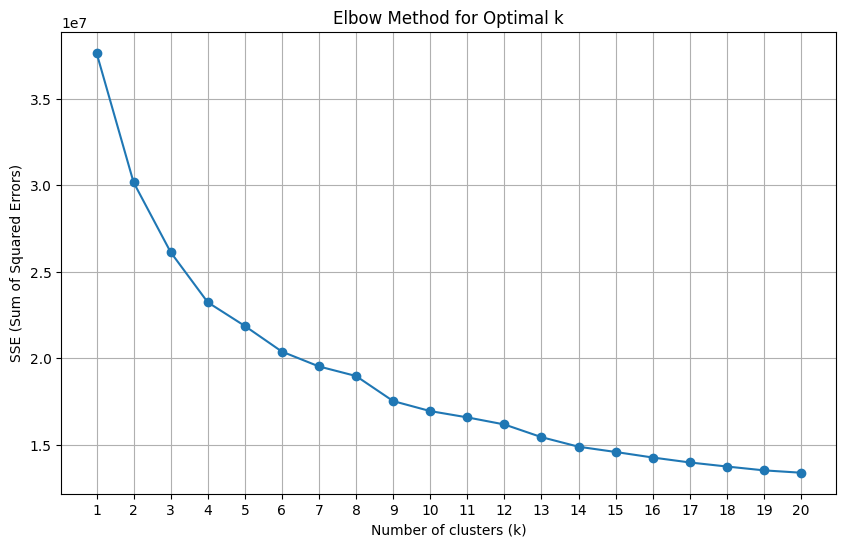

In [ ]:
# 엘보우 메소드 적용
sse = []
k_values = range(1, 21)  # 군집 개수를 1부터 20까지 변화시킵니다.

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca_50)
    sse.append(kmeans.inertia_)  # SSE 값을 저장합니다.

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.xticks(k_values)
plt.grid()
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

<ipython-input-67-1acd44c13a95>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_kmeans = plt.cm.get_cmap('viridis', optimal_k)


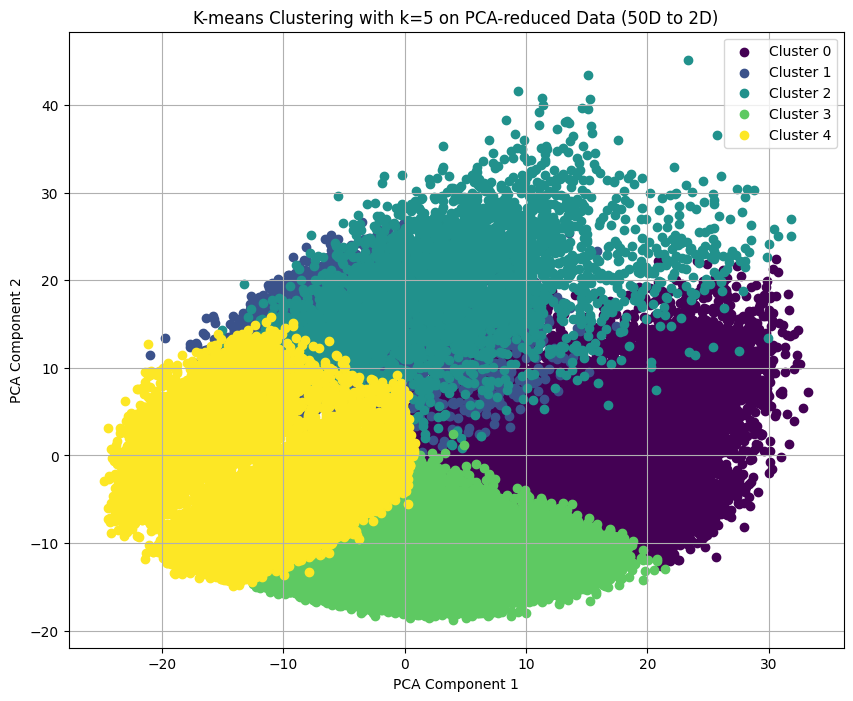

In [ ]:
# K-means 최적의 군집 개수 (5개)로 군집화
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_train_pca_50)

# 시각화
plt.figure(figsize=(10, 8))
colors_kmeans = plt.cm.get_cmap('viridis', optimal_k)

for cluster in range(optimal_k):
    plt.scatter(X_train_pca_50[kmeans_clusters == cluster, 0],
                X_train_pca_50[kmeans_clusters == cluster, 1],
                color=colors_kmeans(cluster),
                label=f'Cluster {cluster}')

plt.title(f'K-means Clustering with k={optimal_k} on PCA-reduced Data (50D to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift

# Gaussian Mixture Model 군집화
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_clusters = gmm.fit_predict(X_train_pca_50)

# Mean Shift 군집화
mean_shift = MeanShift()
mean_shift_clusters = mean_shift.fit_predict(X_train_pca_50)

# Gaussian Mixture Model 시각화
plt.subplot(1, 3, 2)
colors_gmm = plt.cm.get_cmap('viridis', 5)
for cluster in range(5):
    plt.scatter(X_train_pca_50[gmm_clusters == cluster, 0],
                X_train_pca_50[gmm_clusters == cluster, 1],
                color=colors_gmm(cluster),
                label=f'Cluster {cluster}')
plt.title('Gaussian Mixture Model Clustering (k=5)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()

# Mean Shift 시각화
plt.subplot(1, 3, 3)
unique_mean_shift_clusters = np.unique(mean_shift_clusters)
colors_mean_shift = plt.cm.get_cmap('viridis', len(unique_mean_shift_clusters))
for cluster in unique_mean_shift_clusters:
    plt.scatter(X_train_pca_50[mean_shift_clusters == cluster, 0],
                X_train_pca_50[mean_shift_clusters == cluster, 1],
                color=colors_mean_shift(cluster),
                label=f'Cluster {cluster}')
plt.title('Mean Shift Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'X_train_pca_50' is not defined

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.


(더블클릭해서 이곳에 작성)